In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dosya_yolu = "/content/drive/My Drive/Adsız klasör/tarih/to-modelling.csv"
import pandas as pd
df = pd.read_csv(dosya_yolu)
df.head()  # Veriyi görüntüle

,At No,Yaş,Kilo,St,H,Yarış_Id,Tarih,Mesafe,Sıklet,Koşu,...,600m Süre (saniye),400m Süre (saniye),200m Süre (saniye),At_Jokey_Uyumu,At_Pist_Kum_Uyumu,At_Pist_Sentetik_Uyumu,At_Pist_Çim_Uyumu,Mesafe_Kısa,Mesafe_Orta,Mesafe_Uzun
0,1,3,58.7,8,32,1,2024-09-04,1200.0,58,1.0,...,NaN,26.16,NaN,1.000000,5.705882,NaN,7.500000,True,False,False
1,2,4,63.0,2,34,1,2024-09-04,1200.0,58,1.0,...,NaN,26.38,NaN,3.500000,4.375000,6.0,5.904762,False,False,True
2,3,3,59.5,1,34,1,2024-09-04,1200.0,58,1.0,...,41.40,26.54,NaN,3.000000,4.187500,6.0,8.250000,True,False,False
3,4,4,62.5,3,33,1,2024-09-04,1200.0,58,1.0,...,40.60,27.68,NaN,5.000000,5.441860,NaN,6.000000,True,False,False
4,5,3,58.6,4,32,1,2024-09-04,1200.0,58,1.0,...,40.05,26.04,NaN,3.818182,4.250000,NaN,8.000000,False,False,True


In [64]:
df = df.drop(columns=['Derece_saniye'])


In [65]:
import numpy as np

# 1. Yarış ID'lerini al ve karıştır (train/test için)
yarıs_idler = df['Yarış_Id'].unique()
np.random.seed(42)
np.random.shuffle(yarıs_idler)

# 2. %80 train, %20 test olarak böl
train_size = int(0.8 * len(yarıs_idler))
train_yarıs = yarıs_idler[:train_size]
test_yarıs = yarıs_idler[train_size:]

# 3. Yarış bazında ayır
train_df = df[df['Yarış_Id'].isin(train_yarıs)].copy()
test_df = df[df['Yarış_Id'].isin(test_yarıs)].copy()

# 4. Her yarış içindeki atların sırasını rastgele karıştır
train_df = train_df.groupby('Yarış_Id').apply(lambda x: x.sample(frac=1, random_state=42)).reset_index(drop=True)
test_df = test_df.groupby('Yarış_Id').apply(lambda x: x.sample(frac=1, random_state=42)).reset_index(drop=True)

# 5. Feature ve target ayır (At No sıralama hedefimiz)
X_train = train_df.drop(columns=['At No'])
y_train = train_df['At No']

X_test = test_df.drop(columns=['At No'])
y_test = test_df['At No']

In [66]:
X_train = X_train.drop(columns=["Tarih"])
X_test = X_test.drop(columns=["Tarih"])

In [67]:
from lightgbm import early_stopping

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[early_stopping(stopping_rounds=50)]
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4793
[LightGBM] [Info] Number of data points in the train set: 57899, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 5.540925
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's l2: 3.36395


LGBMRegressor(n_estimators=1000, random_state=42)

In [68]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, kendalltau

# Tahmin edilen süreler
y_pred = model.predict(X_test)

# Tahmin sıralaması (küçükten büyüğe)
pred_ranks = pd.Series(y_pred).rank(method='min').astype(int)

# Gerçek sürelerin sıralaması
true_ranks = y_test.rank(method='min').astype(int)

# Spearman sıralama korelasyonu
spearman_corr, _ = spearmanr(true_ranks, pred_ranks)

# Kendall tau korelasyonu
kendall_corr, _ = kendalltau(true_ranks, pred_ranks)

print(f"Spearman Rank Correlation: {spearman_corr:.4f}")
print(f"Kendall Tau Correlation: {kendall_corr:.4f}")

Spearman Rank Correlation: 0.8012
Kendall Tau Correlation: 0.6466


In [69]:
# Test setinde yarış id’lerden birini seçelim
ornek_yaris_id = X_test['Yarış_Id'].iloc[4]

# O yarışa ait satırları seçelim
test_yaris_df = X_test[X_test['Yarış_Id'] == ornek_yaris_id].copy()

# İlgili satırların indeksleri
indices = test_yaris_df.index

# Model tahmini
test_yaris_df['Tahmin'] = model.predict(test_yaris_df)

# Gerçek değerler (target)
test_yaris_df['Gercek'] = y_test.loc[indices]

# Tahmin ve gerçekleri görelim
test_yaris_df = test_yaris_df.sort_values('Tahmin')

print(test_yaris_df[['Tahmin', 'Gercek']])

     Tahmin  Gercek
5  2.542617       3
3  3.095979       1
8  3.887130       4
1  3.946220       2
7  4.433937       5
2  5.780343       6
9  6.652988       7
4  8.017777       8
6  8.463954      10
0  8.641291       9


In [70]:
import pandas as pd
import numpy as np

# Modelin tahminleri (sürekli değerler)
y_pred_continuous = model.predict(X_test)

# Gerçek sıralama (At No)
gercek_siralama = y_test.reset_index(drop=True)

# Yarış Id’leri
yarıs_idleri = X_test['Yarış_Id'].reset_index(drop=True)

# DataFrame oluştur
sonuc_df = pd.DataFrame({
    'Yarış_Id': yarıs_idleri,
    'Gerçek_Sıralama': gercek_siralama,
    'Tahmin_Devamlı': y_pred_continuous
})

# Yarış bazında tahminlere göre sıralama oluştur
sonuc_df['Tahmin_Sıralama'] = sonuc_df.groupby('Yarış_Id')['Tahmin_Devamlı']\
                                     .rank(method='first')\
                                     .astype(int)

print(sonuc_df.head(20))

    Yarış_Id  Gerçek_Sıralama  Tahmin_Devamlı  Tahmin_Sıralama
0          4                9        8.641291               10
1          4                2        3.946220                4
2          4                6        5.780343                6
3          4                1        3.095979                2
4          4                8        8.017777                8
5          4                3        2.542617                1
6          4               10        8.463954                9
7          4                5        4.433937                5
8          4                4        3.887130                3
9          4                7        6.652988                7
10         5                2        4.500097                4
11         5                6        6.013350                6
12         5                1        1.540821                1
13         5                8        6.176948                7
14         5                3        5.010325          

In [71]:
sonuc_df

,Yarış_Id,Gerçek_Sıralama,Tahmin_Devamlı,Tahmin_Sıralama
0,4,9,8.641291,10
1,4,2,3.946220,4
2,4,6,5.780343,6
3,4,1,3.095979,2
4,4,8,8.017777,8
...,...,...,...,...
14253,19720,12,11.936093,12
14254,19720,5,2.651472,1
14255,19720,8,8.805411,11
14256,19720,4,4.515590,5


In [72]:
import numpy as np

sonuc_df['Sıralama_Farkı'] = (sonuc_df['Gerçek_Sıralama'] - sonuc_df['Tahmin_Sıralama']).abs()

ortalama_fark = sonuc_df['Sıralama_Farkı'].mean()
print(f"Genel Ortalama Sıralama Farkı: {ortalama_fark:.4f}")

Genel Ortalama Sıralama Farkı: 1.3156


In [73]:
sonuc_df['Tahmin_Skoru'] = y_pred  # y_pred modelden çıkan tahminlerin array'i

In [74]:
import pandas as pd

# sonuc_df: ['Yarış_Id', 'Gerçek_Sıralama', 'Tahmin_Skoru']

# Tahmin skoruna göre yarış bazında sıralama yap (küçük olan daha iyi)
sonuc_df['Tahmin_Sıralama'] = sonuc_df.groupby('Yarış_Id')['Tahmin_Skoru'].rank(method='min')

ilk_iki_oranlar = []

for yarıs_id, grup in sonuc_df.groupby('Yarış_Id'):
    # Gerçek 1. ve 2.'leri bul
    gercek_ilk_iki = grup[grup['Gerçek_Sıralama'].isin([1, 2])]

    # Tahmin sıralamasına göre ilk 2 olanları bul
    tahmin_ilk_iki = grup.nsmallest(2, 'Tahmin_Skoru')

    # Kaç gerçek ilk iki at tahmin ilk iki içinde var?
    # Çünkü 'At No' yok, burada gerçek ve tahmin atları 1:1 eşleşmiyor,
    # gerçek ve tahmin satırları aynı atı ifade etmiyorsa sadece sıralama karşılaştırılır.
    # Bu yüzden sadece gerçek ilk iki için tahmin sıralamalarına bakıp,
    # tahmin sıralamalarının kaçının 1 veya 2 olduğunu kontrol edebiliriz.

    # Gerçek ilk iki atların tahmin sıralamaları:
    tahmin_siralar = gercek_ilk_iki['Tahmin_Sıralama']

    # Tahmin sıralamalarının içinde 1 veya 2 varsa say
    kac_ilk_iki_var = sum(tahmin_siralar <= 2)

    # 2 tane varsa tam, 1 tane varsa yarım, yoksa 0
    if kac_ilk_iki_var == 2:
        ilk_iki_oranlar.append(1)
    elif kac_ilk_iki_var == 1:
        ilk_iki_oranlar.append(0.5)
    else:
        ilk_iki_oranlar.append(0)

ortalama_oran = sum(ilk_iki_oranlar) / len(ilk_iki_oranlar)
print(f"İlk iki atı sırasız tahmin etme oranı: {ortalama_oran:.4f}")

İlk iki atı sırasız tahmin etme oranı: 0.6286


                   Feature  Importance
35          At_Jokey_Uyumu         771
38       At_Pist_Çim_Uyumu         366
3                        H         360
36       At_Pist_Kum_Uyumu         357
8            Dinlenme_Günü         323
32      600m Süre (saniye)         303
2                       St         293
37  At_Pist_Sentetik_Uyumu         282
4                 Yarış_Id         267
31      800m Süre (saniye)         244
33      400m Süre (saniye)         234
1                     Kilo         228
7                     Koşu         218
26              Jokey_Skor         199
30     1000m Süre (saniye)         195
27                   At_Id         187
23               Anne_Skor         185
25           Antrenor_Skor         183
6                   Sıklet         180
5                   Mesafe         172
24              Sahip_Skor         168
22               Baba_Skor         135
29     1200m Süre (saniye)         106
0                      Yaş          85
34      200m Süre (saniye

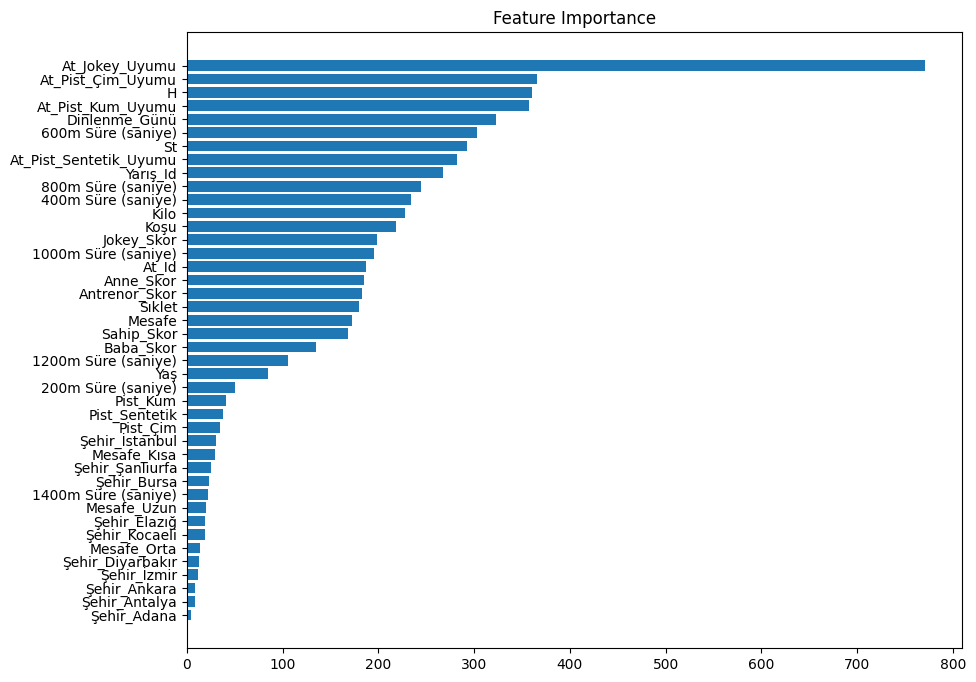

In [75]:
import matplotlib.pyplot as plt
import lightgbm as lgb

# Modelin feature importance skorları (split sayısına göre)
importance = model.feature_importances_

# Özellik isimleri
features = X_train.columns

# Bir DataFrame yapalım
import pandas as pd
fi_df = pd.DataFrame({'Feature': features, 'Importance': importance})

# Önem sırasına göre sırala
fi_df = fi_df.sort_values(by='Importance', ascending=False)

print(fi_df)

# İstersen görselleştirme yapalım
plt.figure(figsize=(10,8))
plt.barh(fi_df['Feature'], fi_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importance')
plt.show()

In [76]:
from google.colab import drive
drive.mount('/content/drive')

import joblib

# Kaydetmek istediğin klasör yolunu belirt
model_path = '/content/drive/MyDrive/Adsız klasör/tarih/lightgbm_model.pkl'
joblib.dump(model, model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/Adsız klasör/tarih/lightgbm_model.pkl']